In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Monte Google Drive vikenvik9@gmail.com


Mounted at /content/drive


In [ ]:
# installer les dépendances
! pip install torch torchvision numpy matplotlib pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
import os
from PIL import Image
import glob
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epochs = 40
lr = 0.0002
image_size = 128
latent_dim = 100
age_threshold = 30  # Seuil d'âge pour considérer une image comme "jeune"

In [ ]:
# Chemin vers UTKFace
dataset_path = "/content/drive/MyDrive/utkcropped"

In [ ]:
# Définition du Dataset UTKFace (sélectionne uniquement les jeunes)
class UTKFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = [p for p in glob.glob(os.path.join(root_dir, "*.jpg"))
                            if int(os.path.basename(p).split("_")[0]) <= age_threshold]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# Charger dataset
dataset = UTKFaceDataset(dataset_path, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Générateur du cGAN
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + 1, 256),  # Ajout d'une condition d'âge
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, image_size * image_size * 3),
            nn.Tanh()
        )

    def forward(self, z, age_label):
        age_label = age_label.view(-1, 1)  # Ajoute une dimension
        input_vector = torch.cat((z, age_label), dim=1)  # Concatène bruit et condition
        img = self.model(input_vector)
        img = img.view(img.size(0), 3, image_size, image_size)
        return img

In [ ]:
# Discriminateur du cGAN
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size * image_size * 3 + 1, 1024),  # Ajout d'une condition d'âge
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, age_label):
        img_flat = img.view(img.size(0), -1)
        age_label = age_label.view(-1, 1)
        input_vector = torch.cat((img_flat, age_label), dim=1)  # Concatène image et condition
        return self.model(input_vector)

In [ ]:
# Initialisation
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

Epoch [0/40], Batch [0/198] - D Loss: 1.3922, G Loss: 0.7532
Epoch [0/40], Batch [100/198] - D Loss: 0.6282, G Loss: 0.8449
Images sauvegardées : progress_epoch_0.png


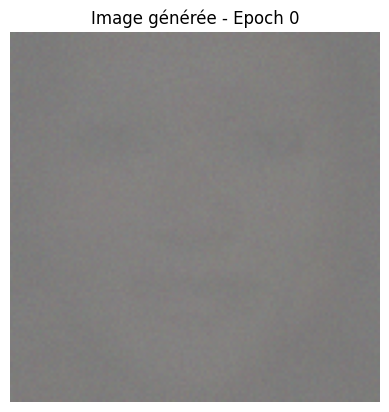

Epoch [1/40], Batch [0/198] - D Loss: 0.5644, G Loss: 1.1087
Epoch [1/40], Batch [100/198] - D Loss: 0.7151, G Loss: 1.5102
Epoch [2/40], Batch [0/198] - D Loss: 1.1278, G Loss: 0.7329
Epoch [2/40], Batch [100/198] - D Loss: 0.3526, G Loss: 1.8886
Epoch [3/40], Batch [0/198] - D Loss: 0.3151, G Loss: 2.2858
Epoch [3/40], Batch [100/198] - D Loss: 0.4006, G Loss: 1.7845
Epoch [4/40], Batch [0/198] - D Loss: 0.4607, G Loss: 1.2188
Epoch [4/40], Batch [100/198] - D Loss: 0.5131, G Loss: 1.7460
Epoch [5/40], Batch [0/198] - D Loss: 0.2857, G Loss: 2.5154
Epoch [5/40], Batch [100/198] - D Loss: 0.5972, G Loss: 2.0457
Epoch [6/40], Batch [0/198] - D Loss: 0.5111, G Loss: 2.3486
Epoch [6/40], Batch [100/198] - D Loss: 0.6609, G Loss: 1.6162
Epoch [7/40], Batch [0/198] - D Loss: 0.6535, G Loss: 2.3658
Epoch [7/40], Batch [100/198] - D Loss: 0.6281, G Loss: 1.9813
Epoch [8/40], Batch [0/198] - D Loss: 0.7074, G Loss: 1.9569
Epoch [8/40], Batch [100/198] - D Loss: 0.8270, G Loss: 2.3216
Epoch [9

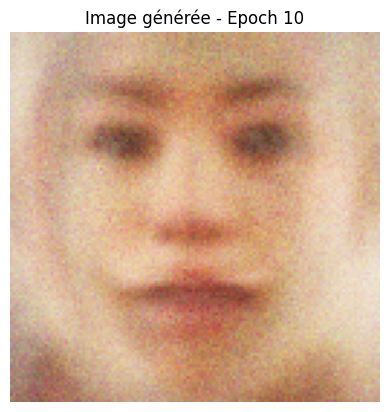

Epoch [11/40], Batch [0/198] - D Loss: 0.7503, G Loss: 2.2862
Epoch [11/40], Batch [100/198] - D Loss: 0.9266, G Loss: 1.9836
Epoch [12/40], Batch [0/198] - D Loss: 0.8132, G Loss: 2.3184
Epoch [12/40], Batch [100/198] - D Loss: 0.6641, G Loss: 2.3996
Epoch [13/40], Batch [0/198] - D Loss: 1.0690, G Loss: 1.8528
Epoch [13/40], Batch [100/198] - D Loss: 0.8516, G Loss: 1.8478
Epoch [14/40], Batch [0/198] - D Loss: 0.7162, G Loss: 2.3308
Epoch [14/40], Batch [100/198] - D Loss: 0.8996, G Loss: 1.9936
Epoch [15/40], Batch [0/198] - D Loss: 0.9389, G Loss: 2.3303
Epoch [15/40], Batch [100/198] - D Loss: 1.0446, G Loss: 1.8302
Epoch [16/40], Batch [0/198] - D Loss: 1.1356, G Loss: 2.8612
Epoch [16/40], Batch [100/198] - D Loss: 1.1096, G Loss: 1.6639
Epoch [17/40], Batch [0/198] - D Loss: 0.8011, G Loss: 2.0424
Epoch [17/40], Batch [100/198] - D Loss: 1.1820, G Loss: 1.7938
Epoch [18/40], Batch [0/198] - D Loss: 1.0616, G Loss: 1.7206
Epoch [18/40], Batch [100/198] - D Loss: 0.9906, G Loss:

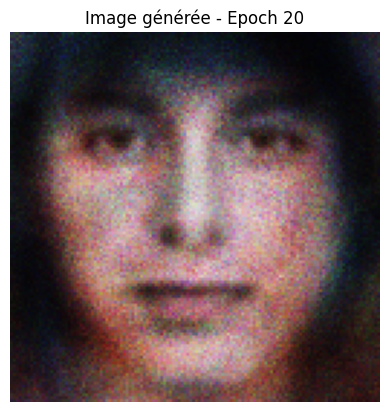

Epoch [21/40], Batch [0/198] - D Loss: 1.0726, G Loss: 1.6895
Epoch [21/40], Batch [100/198] - D Loss: 0.8674, G Loss: 2.0217
Epoch [22/40], Batch [0/198] - D Loss: 0.9272, G Loss: 1.8068
Epoch [22/40], Batch [100/198] - D Loss: 1.0861, G Loss: 1.7865
Epoch [23/40], Batch [0/198] - D Loss: 0.8476, G Loss: 1.9263
Epoch [23/40], Batch [100/198] - D Loss: 0.9576, G Loss: 1.6761
Epoch [24/40], Batch [0/198] - D Loss: 1.0771, G Loss: 1.6990
Epoch [24/40], Batch [100/198] - D Loss: 1.2176, G Loss: 1.6507
Epoch [25/40], Batch [0/198] - D Loss: 1.0714, G Loss: 1.5953
Epoch [25/40], Batch [100/198] - D Loss: 1.0584, G Loss: 1.9914
Epoch [26/40], Batch [0/198] - D Loss: 0.8762, G Loss: 2.0543
Epoch [26/40], Batch [100/198] - D Loss: 1.0653, G Loss: 1.6087
Epoch [27/40], Batch [0/198] - D Loss: 1.0051, G Loss: 1.6650
Epoch [27/40], Batch [100/198] - D Loss: 0.8143, G Loss: 1.9420
Epoch [28/40], Batch [0/198] - D Loss: 0.8386, G Loss: 2.3557
Epoch [28/40], Batch [100/198] - D Loss: 0.9014, G Loss:

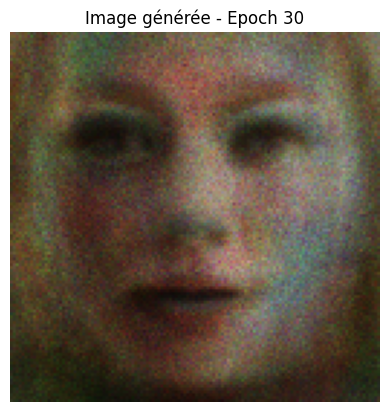

Epoch [31/40], Batch [0/198] - D Loss: 1.0150, G Loss: 1.6750
Epoch [31/40], Batch [100/198] - D Loss: 0.9375, G Loss: 2.1848
Epoch [32/40], Batch [0/198] - D Loss: 0.9698, G Loss: 1.8347
Epoch [32/40], Batch [100/198] - D Loss: 1.0279, G Loss: 1.8596
Epoch [33/40], Batch [0/198] - D Loss: 1.0528, G Loss: 1.7556
Epoch [33/40], Batch [100/198] - D Loss: 0.8608, G Loss: 1.9298
Epoch [34/40], Batch [0/198] - D Loss: 1.2093, G Loss: 1.6985
Epoch [34/40], Batch [100/198] - D Loss: 1.0852, G Loss: 1.8415
Epoch [35/40], Batch [0/198] - D Loss: 1.1358, G Loss: 1.6443
Epoch [35/40], Batch [100/198] - D Loss: 0.9888, G Loss: 1.7856
Epoch [36/40], Batch [0/198] - D Loss: 0.8126, G Loss: 1.8529
Epoch [36/40], Batch [100/198] - D Loss: 1.1644, G Loss: 1.5524
Epoch [37/40], Batch [0/198] - D Loss: 1.1274, G Loss: 1.6362
Epoch [37/40], Batch [100/198] - D Loss: 1.1415, G Loss: 1.7425
Epoch [38/40], Batch [0/198] - D Loss: 0.9706, G Loss: 1.7627
Epoch [38/40], Batch [100/198] - D Loss: 0.8098, G Loss:

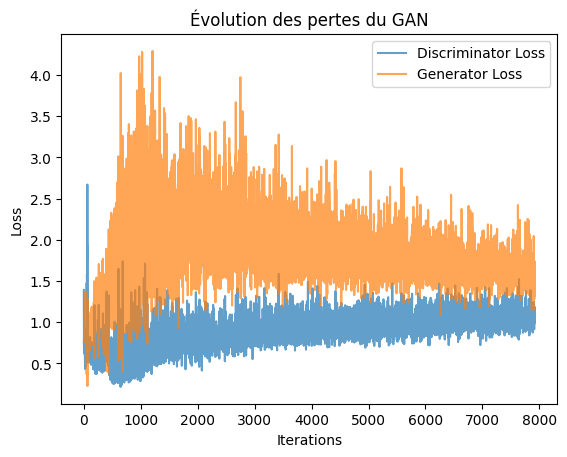

Entraînement terminé !


In [ ]:
# Listes pour suivre les pertes du générateur et du discriminateur
d_losses = []
g_losses = []

# Entraînement du cGAN
for epoch in range(epochs):
    for i, imgs in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels réels et faux
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Générer un âge cible aléatoire (ex: entre 40 et 100 ans)
        target_ages = torch.randint(40, 101, (batch_size,)).float().to(device) / 100.0

        # Entraîner Discriminateur
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z, target_ages)

        real_loss = criterion(discriminator(real_imgs, target_ages), real_labels)
        fake_loss = criterion(discriminator(fake_imgs.detach(), target_ages), fake_labels)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Entraîner Générateur
        g_loss = criterion(discriminator(fake_imgs, target_ages), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # Stocker les pertes pour analyse
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        # **Afficher la progression toutes les 100 itérations**
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}], Batch [{i}/{len(dataloader)}] - "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

            # **Détection de l'effondrement du GAN**
            if d_loss.item() < 0.1:
                print("Attention : le discriminateur devient trop fort ! Ajuste le learning rate ou ajoute du bruit.")

    # **Sauvegarde et affichage des images générées tous les 10 epochs**
    if epoch % 10 == 0:
        save_image(fake_imgs[:25], f"/content/drive/MyDrive/progress_epoch_{epoch}.png", nrow=5, normalize=True)
        print(f"Images sauvegardées : progress_epoch_{epoch}.png")

        # **Afficher une image générée**
        img = fake_imgs[0].cpu().detach().numpy()  # Convertir en numpy
        img = np.transpose(img, (1, 2, 0))  # Repasser en format image (H, W, C)
        img = (img + 1) / 2  # Dé-normaliser pour avoir des valeurs entre 0 et 1

        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Image générée - Epoch {epoch}")
        plt.show()

# **Tracer l'évolution des pertes après l'entraînement**
plt.plot(d_losses, label="Discriminator Loss", alpha=0.7)
plt.plot(g_losses, label="Generator Loss", alpha=0.7)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Évolution des pertes du GAN")
plt.savefig("/content/drive/MyDrive/training_loss_plot.png")
plt.show()

print("Entraînement terminé !")

# Sauvegarde du modèle
torch.save(generator.state_dict(), "/content/drive/MyDrive/face_aging_cgan.pth")